In [1]:
%pip install missingno MissForest lazypredict
%pip install shap


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.executable

'/home/codespace/.python/current/bin/python'

In [3]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import missingno as msno
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import cross_val_score
from lazypredict.Supervised import LazyRegressor
from sklearn.impute import SimpleImputer

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NOTA
El DataFrame df se crea a partir de la tabla basa_datos_pripal de la base de datos credit_scoring.db. El archivo no se incluye en el repositorio debido a su tamaño; la generación de la base de datos a partir del CSV original y la creación de la tabla se explica detalladamente en el notebook data-collection.ipynb

Descriptive analysis:
In this part of the project, we begin exploring the dataset created from the initial information obtained from the LendingClub dataset (Kaggle). The objective of this stage is to describe and understand the structure of the data, the variables and their types, their distributions, skewness, and the presence of missing values.

In [4]:
conn = sqlite3.connect(r"/workspaces/final_project_creditscoring/Data/credit_scoring.db")
df = pd.read_sql("SELECT * FROM main_table", conn)
conn.close()
n_rows,n_cols = df.shape

print(f'En este df existen {n_rows} filas y {n_cols} columnas')

En este df existen 192309 filas y 151 columnas


With the analysis below, we can understand that the dataset contains a large number of numerical variables, along with several categorical features represented as object types. This initial inspection highlights the need for feature selection and type handling in later stages. 

In [5]:
object_cols = df.select_dtypes(include="object").columns.tolist()
int_cols = df.select_dtypes(include="int64").columns.tolist()
float_cols = df.select_dtypes(include="float64").columns.tolist()

print(f"Objects: {len(object_cols)}")
print(f"Ints: {len(int_cols)}")
print(f"Floats: {len(float_cols)}")

Objects: 38
Ints: 1
Floats: 112


The code below is intended to help us understand whether we have incorrectly typed columns that should be numeric instead of objects. The fact that, when we execute the code, the list is empty tells us that our data is mostly properly typed and that we don’t have object columns that should be numbers.

In [6]:
numeric_like = []

for col in object_cols:
    converted = pd.to_numeric(df[col], errors="coerce")
    ratio = converted.notna().mean()

    if ratio > 0.9:  # 90% convertible
        numeric_like.append(col)

numeric_like

[]

In [7]:
for col in object_cols:
    print(f"\n{col}")
    print(df[col].value_counts().head(5))


member_id
Series([], Name: count, dtype: int64)

term
term
36 months    137472
60 months     54837
Name: count, dtype: int64

grade
grade
B    57542
C    51332
A    37335
D    27757
E    12718
Name: count, dtype: int64

sub_grade
sub_grade
B3    12706
B4    12370
C1    12100
B5    11572
C2    11040
Name: count, dtype: int64

emp_title
emp_title
Teacher             2338
Manager             1952
Owner               1249
Supervisor           933
Registered Nurse     921
Name: count, dtype: int64

emp_length
emp_length
10+ years    60263
2 years      17674
< 1 year     16144
3 years      15639
5 years      13163
Name: count, dtype: int64

home_ownership
home_ownership
MORTGAGE    93952
RENT        79309
OWN         18968
ANY            52
OTHER          15
Name: count, dtype: int64

verification_status
verification_status
Source Verified    67530
Not Verified       62455
Verified           62324
Name: count, dtype: int64

issue_d
issue_d
2011-10-01 00:00:00    1941
2011-11-01 00:00:00    

Column format review – findings:
1. No numeric-like object columns detected. All object variables represent categorical or textual information.
2. Multiple date-related columns are stored as object and will require conversion to datetime.
3. Several high-cardinality or free-text columns (emp_title, url, desc) were identified as non-informative for modeling and will be considered for removal in later steps.

Revision of constant columns: 

The following code initially didn’t specify dropna=False, which made it show a few columns as constants. This led us to investigate what was happening and whether we were working with the right dataframe. However, this mistake was enlightening, as it helped us identify possible *data leakage variables, such as: hardship_type, deferral_term, and hardship_length.*

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# Unique values per column
uniq = df.nunique(dropna=False)

# Show results
print(uniq)


id                                            192309
member_id                                          1
loan_amnt                                       1447
funded_amnt                                     1447
funded_amnt_inv                                 4951
term                                               2
int_rate                                         499
installment                                    42629
grade                                              7
sub_grade                                         35
emp_title                                      92975
emp_length                                        12
home_ownership                                     6
annual_inc                                     15656
verification_status                                3
issue_d                                          103
loan_status                                        9
pymnt_plan                                         2
url                                           

In [9]:
uniq = df.nunique(dropna=False)
uniq[uniq == 1]

member_id      1
policy_code    1
dtype: int64

After the code revision, the only two variables with constant values are member_id and policy_code. It does not make much sense to have a unique value for member_id if we have almost 200k data entries, so we needed to check the exact values contained in this column.

In [10]:
cols = ['member_id', 'policy_code']

for col in cols:
    print(df[col].value_counts(dropna=False))

member_id
None    192309
Name: count, dtype: int64
policy_code
1.00    192309
Name: count, dtype: int64


Below, we proceed to drop from the dataset the columns that aren’t relevant to the analysis or that were identified as redundant.

In [11]:
df = df.drop(columns=['member_id', 'policy_code','id','url','emp_title','desc','title'])

Revision of Duplicated Rows: No duplicated rows were identified.

In [12]:
df.duplicated().sum()

np.int64(0)

Revision of Duplicated Columns: Two variables (deferral_term and hardship_length) were found to be exact duplicates, containing identical values across all observations. Both variables are related to post-loan hardship events (we previously identified them as potential data leakers) and will therefore be excluded from the modeling stage. 

In [13]:
df.T.duplicated().sum()
df.T.duplicated(keep=False)

loan_amnt                                     False
funded_amnt                                   False
funded_amnt_inv                               False
term                                          False
int_rate                                      False
installment                                   False
grade                                         False
sub_grade                                     False
emp_length                                    False
home_ownership                                False
annual_inc                                    False
verification_status                           False
issue_d                                       False
loan_status                                   False
pymnt_plan                                    False
purpose                                       False
zip_code                                      False
addr_state                                    False
dti                                           False
delinq_2yrs 

Missing values: 
We identified columns with a high percentage of missing values, so we proceeded to define a missing threshold of 50%, where variables with more than 50% missing values will be considered for exclusion from the modeling stage. However, first we must evaluate them on a case-by-case basis to understand if any of those variables are conceptually important.

In [14]:
missing = df.isna().mean()*100
missing[missing>50]
print(missing)

loan_amnt                                     0.00
funded_amnt                                   0.00
funded_amnt_inv                               0.00
term                                          0.00
int_rate                                      0.00
installment                                   0.00
grade                                         0.00
sub_grade                                     0.00
emp_length                                    5.42
home_ownership                                0.00
annual_inc                                    0.00
verification_status                           0.00
issue_d                                       0.00
loan_status                                   0.00
pymnt_plan                                    0.00
purpose                                       0.00
zip_code                                      0.00
addr_state                                    0.00
dti                                           0.04
delinq_2yrs                    

In [15]:
missing_threshold = 50

high_missing_cols = missing[missing >= missing_threshold]
print(high_missing_cols)

mths_since_last_delinq                       54.78
mths_since_last_record                       87.18
next_pymnt_d                                 75.71
mths_since_last_major_derog                  80.24
annual_inc_joint                             96.91
dti_joint                                    96.91
verification_status_joint                    97.01
open_acc_6m                                  63.20
open_act_il                                  63.20
open_il_12m                                  63.20
open_il_24m                                  63.20
mths_since_rcnt_il                           64.38
total_bal_il                                 63.20
il_util                                      68.58
open_rv_12m                                  63.20
open_rv_24m                                  63.20
max_bal_bc                                   63.20
all_util                                     63.20
inq_fi                                       63.20
total_cu_tl                    

In [16]:
(missing > 0).sum()

np.int64(95)

Now we have to identify other missing values and audit them to understand how we should treat each case.

In [17]:
#Identify other missing values
cat_col = df.select_dtypes(include=['object']).columns

for col in cat_col: 
    print(df[col].value_counts())

term
36 months    137472
60 months     54837
Name: count, dtype: int64
grade
B    57542
C    51332
A    37335
D    27757
E    12718
F     4417
G     1208
Name: count, dtype: int64
sub_grade
B3    12706
B4    12370
C1    12100
B5    11572
C2    11040
B2    10845
B1    10049
C3     9871
C4     9583
A5     9521
A4     9127
C5     8738
D1     6617
A1     6535
D2     6314
A3     6311
A2     5841
D3     5667
D4     4927
D5     4232
E1     3185
E2     2938
E3     2421
E4     2171
E5     2003
F1     1390
F2     1026
F3      861
F4      636
F5      504
G1      404
G2      288
G3      200
G4      184
G5      132
Name: count, dtype: int64
emp_length
10+ years    60263
2 years      17674
< 1 year     16144
3 years      15639
5 years      13163
1 year       12722
4 years      12500
6 years       9969
7 years       8823
8 years       8077
9 years       6907
Name: count, dtype: int64
home_ownership
MORTGAGE    93952
RENT        79309
OWN         18968
ANY            52
OTHER          15
NONE         

In [18]:
df_missing = df.replace(['None'],np.nan,inplace=True)

Columns with more than 50% missing values were manually reviewed and classified into post-loan variables, second-applicant features, structurally missing variables, and late-reported behavioral features based on domain knowledge and data documentation. No features were removed at this stage; the analysis documents decisions to be applied during model preparation.

In [61]:


def classify_column(col):
    # --- POST-LOAN / LEAKAGE (Information from the future) ---
    leakage_list = [
        # Recoveries / payments
        'recoveries', 'collection_recovery_fee', 'total_rec_late_fee',
        'out_prncp', 'out_prncp_inv', 'loan_status',
        'total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt','debt_settlement_flag',
        
        # FICO post-loan
        'last_fico_range_high', 'last_fico_range_low',
        
        # Dates post-loan / monitoring
        'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
        'payment_plan_start_date', 'debt_settlement_flag_date',
        'settlement_date','total_rec_prncp', 'total_rec_int'
    ]
    
    if (
        col.startswith(("hardship", "settlement", "deferral")) or 
        col in leakage_list
    ):
        return "post_loan"

    # --- SECOND APPLICANT ---
    if col.startswith("sec_app") or col.endswith("_joint"):
        return "second_applicant"

    # --- STRUCTURAL MISSING ---
    if col.startswith("mths_since"):
        return "structural_missing"

    # --- EVERYTHING ELSE ---
    return "other"
                                                                                                                                                                    

# Explicit categories (including OTHER)
categories = [
    "post_loan",
    "second_applicant",
    "structural_missing",
    "other"
]

# Build the dictionary of column lists
analysis_dict = {
    cat: [col for col in df.columns if classify_column(col) == cat]
    for cat in categories
}

print("🔍 --- STARTING COLUMN CATEGORIZATION ANALYSIS --- 🔍\n")

for category, cols in analysis_dict.items():
    print(f"📁 CATEGORY: {category.upper()}")
    if not cols:
        print("   ❌ No columns found in this category.\n")
    else:
        print(f"   ✅ Found {len(cols)} columns.")
        missing_stats = df[cols].isnull().mean() * 100
        print(missing_stats.sort_values(ascending=False).to_string())
        print("-" * 40 + "\n")

print("🚀 --- ANALYSIS COMPLETE --- 🚀")


🔍 --- STARTING COLUMN CATEGORIZATION ANALYSIS --- 🔍

📁 CATEGORY: POST_LOAN
   ✅ Found 37 columns.
payment_plan_start_date          99.69
deferral_term                    99.69
hardship_status                  99.69
hardship_reason                  99.69
hardship_type                    99.69
hardship_payoff_balance_amount   99.69
hardship_loan_status             99.69
hardship_dpd                     99.69
hardship_length                  99.69
hardship_amount                  99.69
hardship_end_date                99.69
hardship_start_date              99.69
hardship_last_payment_amount     99.69
settlement_percentage            98.68
settlement_amount                98.68
settlement_term                  98.68
settlement_status                98.68
debt_settlement_flag_date        98.68
settlement_date                  98.68
next_pymnt_d                     75.71
last_pymnt_d                      0.11
last_credit_pull_d                0.00
total_pymnt_inv                   0.00
out_p

orig_projected_additional_accrued_interest   99.76
il_util                                      68.58
all_util                                     63.20
open_rv_24m                                  63.20
open_rv_12m                                  63.20
total_bal_il                                 63.20
open_act_il                                  63.20
max_bal_bc                                   63.20
inq_fi                                       63.20
open_il_24m                                  63.20
open_il_12m                                  63.20
open_acc_6m                                  63.20
inq_last_12m                                 63.20
total_cu_tl                                  63.20
mo_sin_old_il_acct                           25.68
num_tl_120dpd_2m                             25.56
pct_tl_nvr_dlq                               23.15
avg_cur_bal                                  23.14
num_actv_rev_tl                              23.14
total_il_high_credit_limit     

In [20]:
#Column checker: to be able to quickly check the characteristics of a column and its type

target_col = 'loan_status'  

col_type = df[target_col].dtype

summary = pd.DataFrame({
    'Count': df[target_col].value_counts(dropna=False),
    'Percentage (%)': df[target_col].value_counts(dropna=False, normalize=True) * 100
})

print(f"Content Analysis for: {target_col.upper()}")
print(summary)
print('---'*30)
print(f"Data Type: {col_type}")


Content Analysis for: LOAN_STATUS
                                                     Count  Percentage (%)
loan_status                                                               
Fully Paid                                          119522           62.15
Current                                              44223           23.00
Charged Off                                          26066           13.55
Late (31-120 days)                                    1180            0.61
In Grace Period                                        468            0.24
Does not meet the credit policy. Status:Fully Paid     442            0.23
Late (16-30 days)                                      219            0.11
Does not meet the credit policy. Status:Charged...     186            0.10
Default                                                  3            0.00
------------------------------------------------------------------------------------------
Data Type: object


In [21]:
all_classified_cols = (analysis_dict['post_loan'] + 
                      analysis_dict['second_applicant'] + 
                      analysis_dict['structural_missing'])

other_cols = [col for col in df.columns if col not in all_classified_cols]

print("🔍 --- AUDITING 'OTHER' COLUMNS WITH HIGH MISSING RATIO (>40%) ---")
high_missing_other = df[other_cols].isnull().mean()
high_missing_other = high_missing_other[high_missing_other > 0.4].sort_values(ascending=False)

if high_missing_other.empty:
    print("✅ No additional critical missing values found outside defined categories.")
else:
    print("⚠️ Attention: The following columns also have a high missing ratio:")
    print(high_missing_other.to_string())

🔍 --- AUDITING 'OTHER' COLUMNS WITH HIGH MISSING RATIO (>40%) ---
⚠️ Attention: The following columns also have a high missing ratio:
orig_projected_additional_accrued_interest   1.00
il_util                                      0.69
all_util                                     0.63
open_il_12m                                  0.63
open_act_il                                  0.63
open_acc_6m                                  0.63
total_bal_il                                 0.63
open_il_24m                                  0.63
open_rv_24m                                  0.63
open_rv_12m                                  0.63
max_bal_bc                                   0.63
inq_fi                                       0.63
total_cu_tl                                  0.63
inq_last_12m                                 0.63


1. *Post-loan variables:*

These features contain information generated after loan origination, such as hardship or settlement events. Their high missingness reflects the fact that most loans do not enter these processes. Because these variables include future information relative to the credit decision, they were identified as potential sources of data leakage.

Planned decision: Exclude.

2. *Second-applicant variables:*

These variables describe characteristics of a co-borrower in joint loan applications. The high proportion of missing values reflects that most loans involve a single applicant, meaning missing values indicate the absence of a second applicant rather than missing information.

Rather than modeling the full co-borrower profile, the presence of a second applicant is captured through a binary indicator. This approach preserves potentially relevant information while avoiding additional complexity and extensive imputation.

Planned decision: Create a binary flag indicating whether a loan includes a second applicant, and exclude detailed second-applicant features during model preparation.

3. *Structurally missing variables:*

These features represent the time since the last occurrence of negative credit events. Missing values indicate that the event has never occurred, making the missingness itself informative.

Planned decision: Retain for modeling and apply a dedicated imputation strategy at a later stage.

4. *Late-reported features:*

These variables were introduced into the dataset at later periods and are unavailable for older loans. Missingness is driven by historical reporting limitations rather than borrower behavior.

Planned decision: Evaluate after defining the temporal train-test split.

# DATA CLEANING & PREPROCESSING STRATEGY

Now that we have a clearer understanding of the data, we can proceed with data cleaning and processing.

1. DF Backup: Create a full copy of the raw dataset to ensure data integrity and allow for easy rollbacks during the experimentation phase.

2. Target Definition & Filtering: Refine the loan_status variable. We exclude ongoing loans and focus only on definitive outcomes.

Default (1): Charged off, default, or late (30–120 days).
Charged Off
Late (31-120 days)
Default
Does not meet the credit policy. Status:Charged Off

Non-Default (0): Fully paid.
Fully Paid

3. Identification and conversion of date columns (Object to datetime)

4. Zero Ratio & Variance Analysis: Identify features with excessive sparsity. We decide whether to drop columns with near-zero variance or binarize features where the simple presence of an event (0 vs >0) is more predictive than its frequency.

5. Leakage Removal: Drop all Post-loan variables. These features contain information only available after the credit decision has been made, which would lead to Data Leakage.

6. Structural Simplification (Joint Apps): Consolidate +16 second-applicant features into a single Binary Flag (is_joint_application). This reduces dimensionality while preserving the fact that a co-borrower exists.

7. Missingness Audit (Missingno): Visualize the remaining missing values to determine the mechanism of missingness (Random vs. Structural). This dictates the final decision: drop the column (if >50% NaN) or keep it for Imputation after the Train-Test Split.

# 1. DF Backup:

In [22]:
df_backup_raw = df.copy()

# 2.Target Definition & Filtering:

The target variable was binarized by mapping definitive loan outcomes to a binary label. Loans classified as Charged Off, Default, Late (31–120 days), or Does not meet the credit policy. Status: Charged Off were labeled as default (1), while Fully Paid loans were labeled as non-default (0). Only loans with final outcomes were retained.

Default = 1
Non default = 0

In [23]:
df["loan_status"].value_counts()

loan_status
Fully Paid                                             119522
Current                                                 44223
Charged Off                                             26066
Late (31-120 days)                                       1180
In Grace Period                                           468
Does not meet the credit policy. Status:Fully Paid        442
Late (16-30 days)                                         219
Does not meet the credit policy. Status:Charged Off       186
Default                                                     3
Name: count, dtype: int64

In [24]:
default_statuses = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Does not meet the credit policy. Status:Charged Off"
]

non_default_statuses = [
    "Fully Paid"
]

In [25]:
df_target = df[
    df["loan_status"].isin(default_statuses + non_default_statuses)
].copy()

In [26]:
df_target["target_default"] = df_target["loan_status"].apply(
    lambda x: 1 if x in default_statuses else 0
)

In [27]:
df_target["target_default"].value_counts(normalize=True)

target_default
0   0.81
1   0.19
Name: proportion, dtype: float64

In [28]:
pd.crosstab(df_target["loan_status"], df_target["target_default"])

target_default,0,1
loan_status,,
Charged Off,0,26066
Default,0,3
Does not meet the credit policy. Status:Charged Off,0,186
Fully Paid,119522,0
Late (31-120 days),0,1180


In [29]:
print(df_target["loan_status"].value_counts())

loan_status
Fully Paid                                             119522
Charged Off                                             26066
Late (31-120 days)                                       1180
Does not meet the credit policy. Status:Charged Off       186
Default                                                     3
Name: count, dtype: int64


Now we proceed to drop the loan_status column, since it is embedded in the target_default column we created based on the above criteria. Keeping loan_status in the dataset would result in data leakage.

In [30]:
df_target = df_target.drop(columns=["loan_status"])

In [31]:
"loan_status" in df_target.columns

False

In [32]:
print(df_target["target_default"].value_counts())

target_default
0    119522
1     27435
Name: count, dtype: int64


# 3. Identification and conversion of date columns

All date-related features initially stored as object types were identified and converted to datetime format prior to model preparation. This ensures correct temporal handling and enables time-based splitting and feature engineering.

In [33]:
object_cols = df_target.select_dtypes(include="object").columns
object_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint', 'sec_app_earliest_cr_line',
       'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

In [34]:
date_like_cols = []

for col in object_cols:
    try:
        pd.to_datetime(df_target[col].dropna().sample(100), errors="raise")
        date_like_cols.append(col)
    except:
        pass

date_like_cols

['issue_d',
 'earliest_cr_line',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'sec_app_earliest_cr_line',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'debt_settlement_flag_date',
 'settlement_date']

In [35]:
for col in date_like_cols:
    df_target[col] = pd.to_datetime(df_target[col], errors="coerce")

In [36]:
df_target[date_like_cols].dtypes

issue_d                      datetime64[ns]
earliest_cr_line             datetime64[ns]
last_pymnt_d                 datetime64[ns]
next_pymnt_d                 datetime64[ns]
last_credit_pull_d           datetime64[ns]
sec_app_earliest_cr_line     datetime64[ns]
hardship_start_date          datetime64[ns]
hardship_end_date            datetime64[ns]
payment_plan_start_date      datetime64[ns]
debt_settlement_flag_date    datetime64[ns]
settlement_date              datetime64[ns]
dtype: object

# 4. Zero Ratio & Variance Analysis:

A zero ratio analysis was conducted to identify features that could potentially be excluded due to excessive sparsity. Columns with a high proportion of zero values were examined in detail to assess whether zeros reflected a lack of information or meaningful credit history signals.

After reviewing the distribution and non-zero behavior of these features, it was concluded that, in most cases, zero values represent valid and informative states (e.g., absence of adverse credit events) rather than noise. Therefore, no features were removed solely based on their proportion of zero values at this stage. Selected variables were flagged for potential binarization in later modeling iterations if needed.

In [37]:
zero_ratio = (df_target == 0).mean() * 100
zero_ratio = zero_ratio[zero_ratio > 0].sort_values(ascending=False)

zero_ratio.head(20)

delinq_amnt                  99.78
acc_now_delinq               99.69
chargeoff_within_12_mths     99.45
out_prncp                    99.20
out_prncp_inv                99.20
collections_12_mths_ex_med   99.08
tax_liens                    98.00
total_rec_late_fee           95.72
pub_rec_bankruptcies         90.54
collection_recovery_fee      87.78
pub_rec                      87.53
recoveries                   85.75
delinq_2yrs                  83.44
target_default               81.33
num_tl_30dpd                 69.83
num_tl_120dpd_2m             67.90
num_tl_90g_dpd_24m           66.11
tot_coll_amt                 60.42
num_accts_ever_120_pd        54.38
inq_last_6mths               53.74
dtype: float64

In [38]:
HIGH_ZERO_THRESHOLD = 30.0

high_zero_cols = zero_ratio[zero_ratio > HIGH_ZERO_THRESHOLD].index.tolist()
len(high_zero_cols), high_zero_cols[:10]

(21,
 ['delinq_amnt',
  'acc_now_delinq',
  'chargeoff_within_12_mths',
  'out_prncp',
  'out_prncp_inv',
  'collections_12_mths_ex_med',
  'tax_liens',
  'total_rec_late_fee',
  'pub_rec_bankruptcies',
  'collection_recovery_fee'])

In [39]:
def audit_high_zero_columns(df, cols):
    rows = []
    for col in cols:
        zr = zero_ratio[col]
        non_zero = df.loc[df[col] != 0, col]
        uniq_nz = non_zero.nunique()
        top_share = df[col].value_counts(normalize=True, dropna=False).iloc[0]

        rows.append({
            "column": col,
            "zero_pct": round(zr, 2),
            "non_zero_unique": int(uniq_nz),
            "top_value_share": round(top_share, 3),
            "non_zero_min": non_zero.min() if len(non_zero) else np.nan,
            "non_zero_max": non_zero.max() if len(non_zero) else np.nan,
        })
    return pd.DataFrame(rows).sort_values("zero_pct", ascending=False)

audit_df = audit_high_zero_columns(df_target, high_zero_cols)
audit_df.head(15)

,column,zero_pct,non_zero_unique,top_value_share,non_zero_min,non_zero_max
0,delinq_amnt,99.78,256,1.00,2.00,65000.00
1,acc_now_delinq,99.69,3,1.00,1.00,3.00
2,chargeoff_within_12_mths,99.45,6,0.99,1.00,9.00
3,out_prncp,99.20,1178,0.99,1.83,39003.81
4,out_prncp_inv,99.20,1178,0.99,1.83,39003.81
5,collections_12_mths_ex_med,99.08,8,0.99,1.00,20.00
6,tax_liens,98.00,14,0.98,1.00,39.00
7,total_rec_late_fee,95.72,4220,0.96,0.00,1098.36
8,pub_rec_bankruptcies,90.54,7,0.91,1.00,8.00
9,collection_recovery_fee,87.78,16329,0.88,0.04,7002.19


In [40]:
LOW_VARIANCE_THRESHOLD = 0.99

low_variance_cols = audit_df.loc[
    audit_df["top_value_share"] > LOW_VARIANCE_THRESHOLD, "column"
].tolist()

low_variance_cols

['delinq_amnt',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'out_prncp',
 'out_prncp_inv',
 'collections_12_mths_ex_med']

In [41]:
ZERO_KEEP_COLS = [
    "tax_liens",
    "pub_rec",
    "delinq_2yrs",
    "num_tl_90g_dpd_24m",
    "num_accts_ever_120_pd",
    "mort_acc",
    "tot_coll_amt",
    "inq_last_6mths",
    "delinq_amnt",
    "acc_now_delinq",
    "chargeoff_within_12_mths",
    "collections_12_mths_ex_med",
]

ZERO_BINARIZE_COLS = [
    "pub_rec_bankruptcies",
    "num_tl_30dpd",
    "num_tl_120dpd_2m",
]

ZERO_DROP_COLS = []

In [42]:
desc = df.describe().T
desc.sort_values(by='max', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
annual_inc,192309.00,75169.59,69239.42,0.00,45000.00,64000.00,90000.00,8700000.00
tot_hi_cred_lim,147812.00,174407.64,175198.13,0.00,49067.75,112098.50,254223.00,5850873.00
tot_cur_bal,147812.00,140579.79,157130.29,0.00,28571.75,78569.00,211994.75,5327039.00
annual_inc_joint,5947.00,122752.27,65794.04,13464.00,82772.00,110000.00,146000.00,1500000.00
total_rev_hi_lim,147812.00,33396.41,33326.34,0.00,14400.00,24700.00,41500.00,1417100.00
total_bal_ex_mort,157627.00,48858.28,47215.88,0.00,20217.00,36431.00,61609.50,1276247.00
total_il_high_credit_limit,147812.00,41767.31,43336.43,0.00,14006.75,31084.00,56414.25,1214546.00
revol_bal,192309.00,16045.89,20507.66,0.00,5860.00,11215.00,19809.00,1190046.00
total_bal_il,70775.00,35223.41,43461.04,0.00,8607.50,22890.00,46015.50,801779.00
total_bc_limit,157627.00,22276.56,21968.83,0.00,8000.00,15700.00,29000.00,520500.00


The analysis of the maximum values reveals the presence of extreme values in some financial variables, which suggests the need to apply transformations or outlier treatment techniques in later stages.

In [43]:
desc.assign(
    mean_median_ratio = desc['mean'] / desc['50%']
).sort_values('mean_median_ratio', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max,mean_median_ratio
pub_rec,192309.00,0.16,0.50,0.00,0.00,0.00,0.00,40.00,inf
inq_last_6mths,192309.00,0.68,0.98,0.00,0.00,0.00,1.00,8.00,inf
delinq_2yrs,192309.00,0.27,0.80,0.00,0.00,0.00,0.00,26.00,inf
total_rec_late_fee,192309.00,1.42,11.19,0.00,0.00,0.00,0.00,1098.36,inf
recoveries,192309.00,153.45,774.14,0.00,0.00,0.00,0.00,35581.88,inf
out_prncp_inv,192309.00,2404.69,5862.74,0.00,0.00,0.00,0.00,39091.64,inf
open_il_12m,70775.00,0.67,0.93,0.00,0.00,0.00,1.00,20.00,inf
acc_now_delinq,192309.00,0.00,0.06,0.00,0.00,0.00,0.00,3.00,inf
tot_coll_amt,147812.00,201.41,1907.32,0.00,0.00,0.00,0.00,380757.00,inf
collection_recovery_fee,192309.00,22.34,128.94,0.00,0.00,0.00,0.00,7002.19,inf


Several numerical variables present highly skewed distributions, with median values equal to zero and a small proportion of non-zero observations. This pattern is expected for count-based credit history variables. However, some highly skewed variables correspond to post-loan information and will therefore be excluded from the modeling process to prevent data leakage.

# 5. Leakage Removal and Structural Simplification (Joint Apps)

To prevent data leakage, all post-loan variables—i.e., features containing information only available after loan origination—were removed from the dataset. These variables capture outcomes or events occurring after the credit decision and would artificially inflate model performance if retained.

Additionally, second-applicant (joint application) variables were consolidated to reduce dimensionality while preserving relevant information. A binary flag (is_joint_application) was created to indicate whether a loan was issued jointly or individually. After creating this flag, all detailed second-applicant features were removed from the feature set.

This approach ensures that the model relies exclusively on information available at the time of the credit decision while maintaining a simplified and consistent feature space.

is_joint_application = 0 → Individual loan (single applicant)
is_joint_application = 1 → Joint loan (co-applicant present)

In [44]:
df_model = df_target.copy()

In [45]:
df_model["is_joint_application"] = (
    df_model[analysis_dict["second_applicant"]]
    .notna()
    .any(axis=1)
    .astype(int)
)

In [46]:
post_loan_cols = analysis_dict["post_loan"]
second_applicant_cols = analysis_dict["second_applicant"]

In [47]:
cols_to_drop = post_loan_cols + second_applicant_cols

df_model = df_model.drop(columns=cols_to_drop, errors="ignore")

In [48]:
print("Post-loan remaining:", set(post_loan_cols) & set(df_model.columns))
print("Second applicant remaining:", set(second_applicant_cols) & set(df_model.columns))
print("Flag distribution:")
print(df_model["is_joint_application"].value_counts())

Post-loan remaining: set()
Second applicant remaining: set()
Flag distribution:
is_joint_application
0    145468
1      1489
Name: count, dtype: int64


In [49]:
df_model.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,orig_projected_additional_accrued_interest,disbursement_method,debt_settlement_flag,target_default,is_joint_application
0,21000.00,13225.00,12822.85,60 months,13.61,305.06,C,C2,1 year,MORTGAGE,...,0.00,NaN,NaN,NaN,NaN,NaN,Cash,N,0,0
1,4500.00,4500.00,4500.00,60 months,16.82,111.41,E,E2,4 years,RENT,...,0.00,NaN,NaN,NaN,NaN,NaN,Cash,N,0,0
2,8000.00,8000.00,7540.08,36 months,7.88,250.25,A,A5,< 1 year,RENT,...,0.00,NaN,NaN,NaN,NaN,NaN,Cash,N,0,0
3,18200.00,18200.00,17054.54,36 months,7.51,566.22,A,A4,2 years,MORTGAGE,...,0.00,NaN,NaN,NaN,NaN,NaN,Cash,N,0,0
4,20000.00,20000.00,19811.52,60 months,15.70,483.18,D,D4,10+ years,MORTGAGE,...,0.00,NaN,NaN,NaN,NaN,NaN,Cash,N,0,0


# 6. Missingness Audit (Missingno)

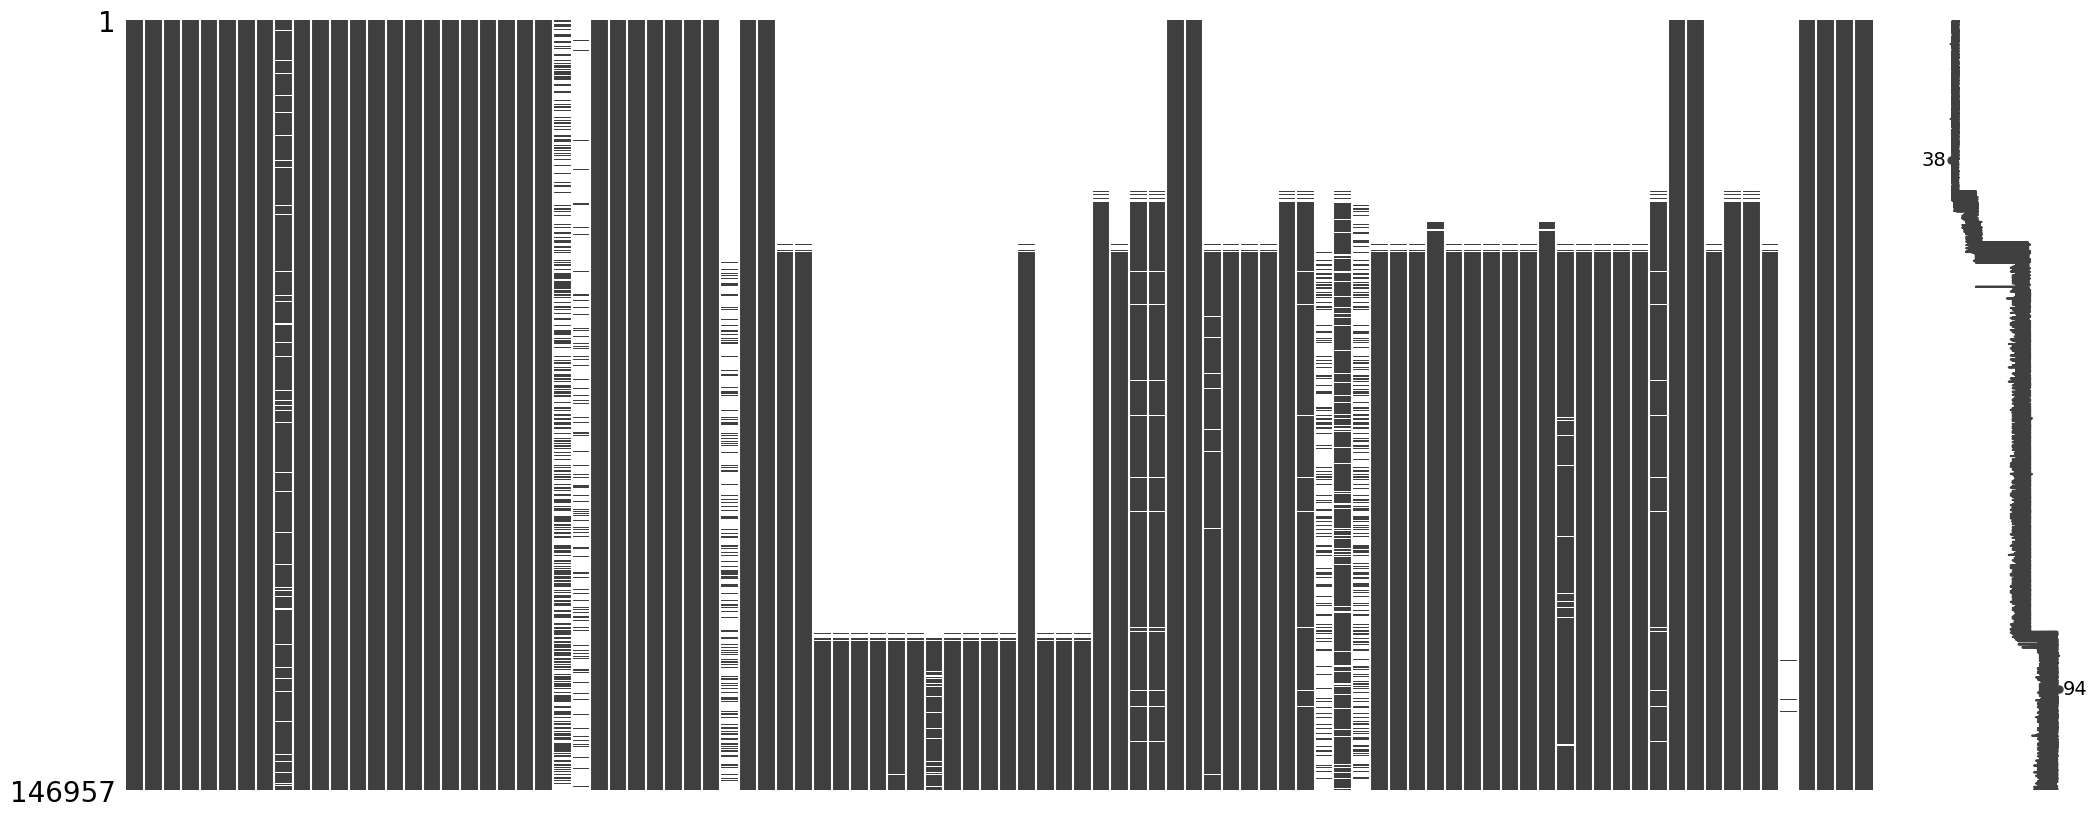

In [50]:
msno.matrix(df_model)
plt.show()

After reviewing the missingno matrix, we performed a final audit to capture residual data leakage that bypassed our initial classification rules. Additionally, we identified a group of variables introduced by Lending Club in late 2015 (such as il_util and open_acc_6m). Since these features are missing in over 80% of our historical records, their inclusion would introduce a historical cohort bias. To ensure model stability and prevent the Logistic Regression from learning patterns based on data availability periods rather than credit risk, we decided to remove them.

In [51]:
# Check exactly what's left with high missingness
missing_report = df_model.isnull().mean().sort_values(ascending=False) * 100
print("--- Features with highest missingness (%) ---")
print(missing_report.head(40))

--- Features with highest missingness (%) ---
orig_projected_additional_accrued_interest   99.81
mths_since_last_record                       87.53
il_util                                      82.82
mths_since_recent_bc_dlq                     82.68
mths_since_last_major_derog                  81.76
mths_since_rcnt_il                           80.63
all_util                                     80.10
open_act_il                                  80.10
open_il_12m                                  80.10
total_cu_tl                                  80.10
inq_last_12m                                 80.10
max_bal_bc                                   80.10
open_rv_24m                                  80.10
open_rv_12m                                  80.10
open_acc_6m                                  80.10
total_bal_il                                 80.10
inq_fi                                       80.10
open_il_24m                                  80.10
mths_since_recent_revol_delinq      

In [52]:
# Define leakage columns and variables with >80% missing values (except mths_since)
leakage_to_drop = [
    'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 
    'next_pymnt_d', 'debt_settlement_flag_date','last_pymnt_d','last_credit_pull_d'
]

# Define leakage columns and variables with more than 80% missing values (except mths_since).
high_null_noise = [
    'il_util', 'all_util', 'open_acc_6m', 'open_act_il', 'open_il_12m', 
    'open_il_24m', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 
    'total_bal_il', 'inq_last_12m', 'inq_fi', 'total_cu_tl', 'mths_since_rcnt_il'
]

# Execute drop
cols_to_remove = leakage_to_drop + high_null_noise
df_model.drop(columns=[c for c in cols_to_remove if c in df_model.columns], inplace=True)

print(f"✅ Limpieza final de df_model completada.")
print(f"Columnas restantes: {df_model.shape[1]}")

✅ Limpieza final de df_model completada.
Columnas restantes: 79


In [53]:
# Final reporting post noise cleaning
missing_report_final = df_model.isnull().mean().sort_values(ascending=False) * 100
print("--- Final Missingness Report (df_model) ---")
print(missing_report_final[missing_report_final > 0])

--- Final Missingness Report (df_model) ---
mths_since_last_record           87.53
mths_since_recent_bc_dlq         82.68
mths_since_last_major_derog      81.76
mths_since_recent_revol_delinq   74.47
mths_since_last_delinq           55.49
mo_sin_old_il_acct               32.23
num_tl_120dpd_2m                 32.05
mths_since_recent_inq            31.21
pct_tl_nvr_dlq                   29.99
avg_cur_bal                      29.98
mo_sin_old_rev_tl_op             29.98
tot_cur_bal                      29.98
num_actv_bc_tl                   29.98
total_rev_hi_lim                 29.98
tot_coll_amt                     29.98
num_actv_rev_tl                  29.98
num_bc_tl                        29.98
num_tl_90g_dpd_24m               29.98
num_tl_30dpd                     29.98
num_op_rev_tl                    29.98
num_il_tl                        29.98
num_rev_accts                    29.98
num_rev_tl_bal_gt_0              29.98
mo_sin_rcnt_tl                   29.98
num_accts_ever_120_p

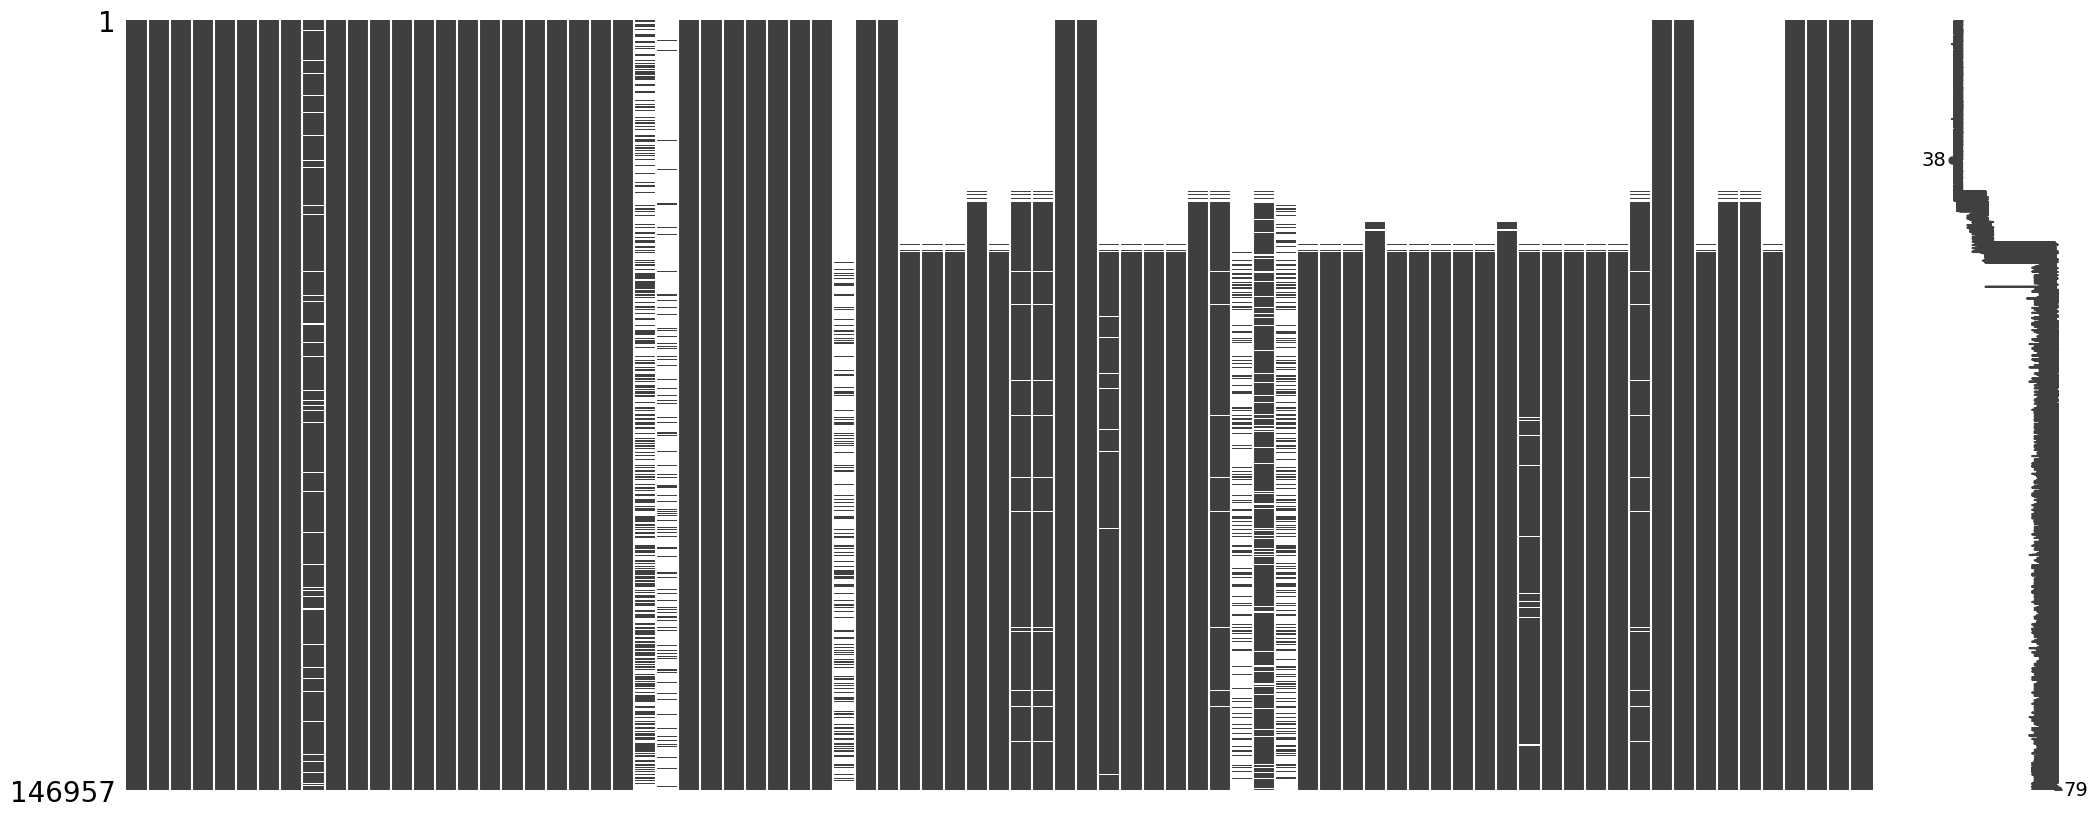

In [54]:
msno.matrix(df_model)
plt.show()

The missingno matrix confirms that data is missing in logical patterns rather than randomly. We identified two main types of missingness:

Structural (Informative): Columns like mths_since_last_delinq (55-88% missing) represent borrowers with no negative credit events. These are informative nulls that we will preserve and impute with a sentinel value (999).

Technical Blocks: A significant block of features (30% missing) fails simultaneously. The Heatmap shows 1.0 correlations between these nulls, proving they are record-level gaps from the credit bureau.

Conclusion: The high correlation between missing values confirms that data fails in blocks. This justifies a consistent strategy: median imputation for technical blocks and sentinel values (999) for structural features, ensuring the model captures both the presence and absence of credit history correctly.

# Train Test Split

Instead of a standard random shuffle, we implemented a Temporal Split based on the loan issuance date (issue_d). We sorted the data chronologically and used the first 80% of the records (2010–2015) for training, while reserving the most recent 20% (2016–2018) as an Out-of-Time (OOT) test set.

Rational: In credit risk modeling, it is vital to ensure the model can generalize to future economic conditions. A temporal split is the most realistic evaluation method because it prevents Look-ahead Bias (training on future information to predict the past). Our results show that the default rate increased from 17% in the training period to 25.4% in the test period. This shift represents a real-world challenge: the model must be robust enough to maintain predictive power even when the macroeconomic environment or borrower profiles evolve over time.

In [55]:
#Frequency count 
print(df_model['target_default'].value_counts())

target_default
0    119522
1     27435
Name: count, dtype: int64


In [56]:
X = df_model.drop(columns=['target_default'])  
y = df_model['target_default']                 # Target

# Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

In [57]:
#Separate numerical and categorical features

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numerical columns: 62
Categorical columns: 14


#Numerical Strategic Imputation (Structural & General)

Imputation will be performed following a dual strategy based on the nature of the missing data:

Structural Missingness: Missing numerical values are handled using an explicit missing indicator combined with median imputation, preserving the information that an event never occurred while avoiding artificial extreme values.

Median/Mode Imputation: For technical gaps or random missingness, we will use the Median for numerical features and the Mode for categorical ones.

Rational: To prevent Data Leakage, all imputation parameters (medians and modes) will be calculated strictly using the Training Set (X_train). These parameters will then be applied to both the training and test sets. This ensures that the test set remains completely "unseen" and that no information from the 2016–2018 period influences the 2010–2015 training phase.

#Missing Value Imputation (post–split)

All imputation strategies are fit on the training set only and then applied to the test set, to avoid data leakage.

In [58]:
cols_to_drop = ['outlier_flag', 'real_outlier']

X_train = X_train.drop(columns=[c for c in cols_to_drop if c in X_train.columns])
X_test  = X_test.drop(columns=[c for c in cols_to_drop if c in X_test.columns])


In [ ]:

# Identify numerical columns
num_cols = X_train.select_dtypes(include='number').columns

# Identify structurally missing columns
mths_since_cols = [c for c in num_cols if c.startswith('mths_since')]

# Create missing indicators
for col in mths_since_cols:
    X_train[f"{col}_missing"] = X_train[col].isna().astype(int)
    X_test[f"{col}_missing"]  = X_test[col].isna().astype(int)

# Median imputation (fit on train only)
num_imputer = SimpleImputer(strategy='median')

X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols]  = num_imputer.transform(X_test[num_cols])

# Sanity check
print("Numerical nulls left in X_train:", X_train[num_cols].isna().sum().sum())
print("Numerical nulls left in X_test:", X_test[num_cols].isna().sum().sum())


Numerical nulls left in X_train: 0
Numerical nulls left in X_test: 0


OJO: Aca quede. Queda pendiente agregar explicacion de estrategia y entender por que sigo teniendo 999 en columnas.... arreglar el tema de outliers y verificar cuantos outliers reales tenemos ahora para seguir trabajando en las sigueintes features

In [64]:
assert set(X_train.columns) == set(X_test.columns)

In [65]:
# Check for remaining nulls in numerical columns
num_nulls = X_train.select_dtypes(include=['number']).isnull().sum().sum()
print(f"Total numerical nulls: {num_nulls}")

Total numerical nulls: 0


In [66]:
# Check if 999 exists in structural columns
print(X_train[mths_since_cols].describe().loc[['min', 'max']])

     mths_since_last_delinq  mths_since_last_record  \
min                    0.00                    0.00   
max                  180.00                  121.00   

     mths_since_last_major_derog  mths_since_recent_bc  \
min                         0.00                  0.00   
max                       180.00                439.00   

     mths_since_recent_bc_dlq  mths_since_recent_inq  \
min                      0.00                   0.00   
max                    171.00                  25.00   

     mths_since_recent_revol_delinq  
min                            0.00  
max                          180.00  


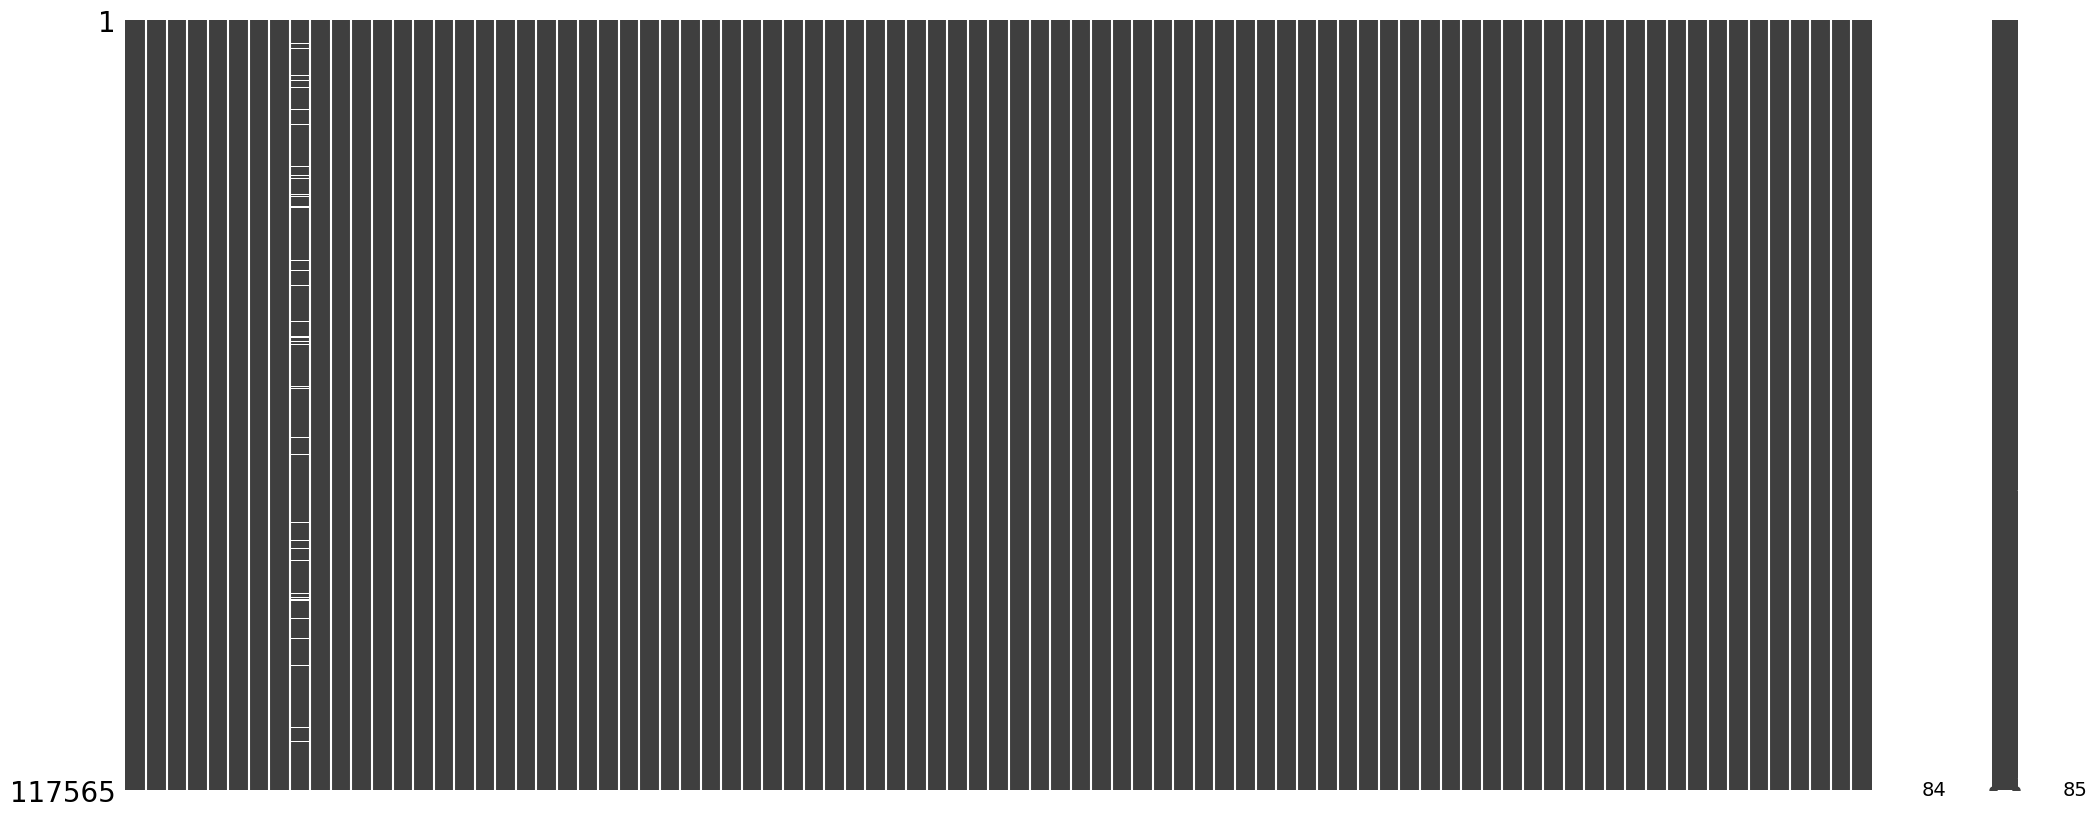

In [67]:
msno.matrix(X_train)
plt.show()

In [68]:
#Check for missing values in all categorical variables
print("Null count in Categorical Columns:")
print(X_train[cat_cols].isnull().sum())

Null count in Categorical Columns:
term                       0
grade                      0
sub_grade                  0
emp_length              5613
home_ownership             0
verification_status        0
pymnt_plan                 0
purpose                    0
zip_code                   0
addr_state                 0
initial_list_status        0
application_type           0
disbursement_method        0
debt_settlement_flag       0
dtype: int64


The missingno matrix appears to show only one categorical feature because it exclusively highlights columns with missing data. While X_train contains 14 categorical features, 13 of them are 100% complete and appear as solid black bars. Only emp_length exhibits the "striped" pattern indicating missing values.

For emp_length, missing values often represent either structural omission or cases where the borrower's employment status doesn't fit standard categories. Imputing with the Mode maintains the existing distribution's strength, while an "Unknown" category avoids making assumptions about the borrower's stability. Given that this variable represents a significant proxy for credit risk stability, we will treat it with care during the encoding phase.

In [69]:
# Manual imputation of categorical 
X_train['emp_length'] = X_train['emp_length'].fillna('Unknown')
X_test['emp_length'] = X_test['emp_length'].fillna('Unknown')

# Final verification
print(f"Remaining nulls in emp_length: {X_train['emp_length'].isnull().sum()}")

Remaining nulls in emp_length: 0


In [70]:
# CATEGORICAL IMPUTATION

# Apply "Unknown" to categorical nulls to avoid bias
for col in cat_cols:
    if X_train[col].isnull().any():
        X_train[col] = X_train[col].fillna('Unknown')
        X_test[col] = X_test[col].fillna('Unknown')

print("✅ Categorical imputation complete using 'Unknown' label.")
print(f"Total nulls in X_train: {X_train.isnull().sum().sum()}")

✅ Categorical imputation complete using 'Unknown' label.
Total nulls in X_train: 0


#Categorical Feature audit and strategy

Before applying any encoding, we must categorize each of the 14 features based on their mathematical relationship with the target variable:

- Binary: Features with only two possible values (e.g., term, pymnt_plan). These can be directly mapped to 0 and 1.

- Ordinal: Features with a natural, inherent rank (e.g., grade A > B > C). These require Label Encoding or Mapping to preserve the risk hierarchy.

- Nominal (Low Cardinality): Categories without order and few unique values (e.g., home_ownership). These are ideal for One-Hot Encoding.

- Nominal (High Cardinality): Categories with many unique values (e.g., addr_state, purpose). These require grouping or special handling to avoid creating hundreds of sparse columns.

Using a "one-size-fits-all" approach would create an excessively sparse matrix, potentially leading to overfitting or the "curse of dimensionality." A tailored strategy ensures the model captures the underlying risk signals efficiently.

In [71]:
# Analyzing the nature of the 14 categorical variables
cat_summary = []

for col in cat_cols:
    cat_summary.append({
        'Feature': col,
        'Unique_Values': X_train[col].nunique(),
        'Sample_Values': X_train[col].unique()[:5].tolist(),
    })

import pandas as pd
df_cat_audit = pd.DataFrame(cat_summary)
print("🔍 --- CATEGORICAL AUDIT --- 🔍")
print(df_cat_audit)

🔍 --- CATEGORICAL AUDIT --- 🔍
                 Feature  Unique_Values  \
0                   term              2   
1                  grade              7   
2              sub_grade             35   
3             emp_length             12   
4         home_ownership              6   
5    verification_status              3   
6             pymnt_plan              2   
7                purpose             14   
8               zip_code            883   
9             addr_state             51   
10   initial_list_status              2   
11      application_type              2   
12   disbursement_method              2   
13  debt_settlement_flag              2   

                                        Sample_Values  
0                            [ 36 months,  60 months]  
1                                     [A, B, D, C, E]  
2                                [A5, B2, B1, D1, B3]  
3     [10+ years, 2 years, < 1 year, Unknown, 1 year]  
4                   [RENT, MORTGAGE, OWN, AN

Based on the Categorical Audit, we have identified four distinct groups of features that require tailored encoding techniques to optimize the Logistic Regression model:

- Binary Features (0 or 1): Features like term, pymnt_plan, initial_list_status, application_type, and debt_settlement_flag. These have exactly 2 unique values and will be mapped to a binary integer format.

- Ordinal Features (Ordered Rank): grade, sub_grade, and emp_length. These carry a natural hierarchy of risk (e.g., Grade A is safer than Grade G). We will use Ordinal Mapping to preserve this mathematical relationship.

- Nominal Low-Cardinality (One-Hot): home_ownership, verification_status, and purpose (14 values). These have no inherent order and few categories, making them ideal for One-Hot Encoding.

- High-Cardinality/Redundant: zip_code (867 values) and addr_state (51 values) create too much noise for a Logistic Regression. disbursement_method only has 1 value ("Cash"), meaning it provides zero predictive power and should be dropped.

Preserving the order in grade and sub_grade is critical because a linear model like Logistic Regression can learn that risk increases as the grade moves from 1 to 7. Conversely, One-Hot Encoding these would treat the difference between A and B the same as the difference between A and G, losing valuable information.

In [72]:
# Drop constant features
X_train.drop(columns=['disbursement_method'], inplace=True, errors='ignore')
X_test.drop(columns=['disbursement_method'], inplace=True, errors='ignore')

In [73]:
# 1. Mapping Grades (A=1, B=2... G=7)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
X_train['grade'] = X_train['grade'].map(grade_map)
X_test['grade'] = X_test['grade'].map(grade_map)

# 2. Mapping emp_length (Converting strings to numbers)
emp_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
    '10+ years': 10, 'Unknown': -1 # We use -1 as our "missing" signal here
}
X_train['emp_length'] = X_train['emp_length'].map(emp_map)
X_test['emp_length'] = X_test['emp_length'].map(emp_map)

In [74]:
# Encoding 'term' (36 months = 0, 60 months = 1)
X_train['term'] = X_train['term'].apply(lambda x: 1 if '60' in x else 0)
X_test['term'] = X_test['term'].apply(lambda x: 1 if '60' in x else 0)

In [75]:
# CLEANING HIGH-CARDINALITY & REDUNDANT FEATURES

# 1. List of features to drop
cols_to_drop_final = ['zip_code', 'addr_state', 'disbursement_method']

# 2. Execute drop
X_train.drop(columns=[c for c in cols_to_drop_final if c in X_train.columns], inplace=True)
X_test.drop(columns=[c for c in cols_to_drop_final if c in X_test.columns], inplace=True)

# 3. Update our categorical list
cat_cols = [c for c in cat_cols if c not in cols_to_drop_final]

print(f"✅ High-cardinality and redundant features removed.")
print(f"Remaining categorical columns for One-Hot Encoding: {len(cat_cols)}")

✅ High-cardinality and redundant features removed.
Remaining categorical columns for One-Hot Encoding: 11


In [76]:
# Update the list of categorical columns based on the current state of X_train
cat_cols_remaining = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"🔍 --- REMAINING CATEGORICAL COLUMNS ({len(cat_cols_remaining)}) --- 🔍")
for i, col in enumerate(cat_cols_remaining):
    unique_count = X_train[col].nunique()
    print(f"{i+1}. {col:25} | Unique Values: {unique_count}")

# Quick check of the ones we already mapped
print("\n✅ Verification of previously mapped columns:")
print(f"Grade type:      {X_train['grade'].dtype}")
print(f"Emp_length type: {X_train['emp_length'].dtype}")

🔍 --- REMAINING CATEGORICAL COLUMNS (8) --- 🔍
1. sub_grade                 | Unique Values: 35
2. home_ownership            | Unique Values: 6
3. verification_status       | Unique Values: 3
4. pymnt_plan                | Unique Values: 2
5. purpose                   | Unique Values: 14
6. initial_list_status       | Unique Values: 2
7. application_type          | Unique Values: 2
8. debt_settlement_flag      | Unique Values: 2

✅ Verification of previously mapped columns:
Grade type:      int64
Emp_length type: int64


The final stage of feature engineering focuses on the remaining 8 variables. We apply a differentiated approach to maximize the model's predictive power:

-Sub-grade (Ordinal Mapping): Given that sub_grade contains 35 levels with a clear risk hierarchy (e.g., A1 is safer than G5), we map it to a range of 1 to 35. This allows the Logistic Regression to treat the grade as a continuous risk indicator rather than independent, unrelated categories.

-Nominal Features (One-Hot Encoding): For the remaining 7 features such as home_ownership and purpose, we use One-Hot Encoding. This creates binary (0 or 1) columns for each category, which is the standard requirement for linear models to process non-ordered data.

Completing this step ensures the dataset is 100% numerical. By using pd.get_dummies with drop_first=True, we avoid the "dummy variable trap" (multicollinearity), which is essential for the stability of Logistic Regression coefficients.

In [77]:
# 1. Ordinal mapping of Sub-Grade (A1=1, A2=2... G5=35)
# We generate the mapping based on the natural alphabetical/numerical order
sub_grade_list = sorted(X_train['sub_grade'].unique())
sub_grade_map = {val: i+1 for i, val in enumerate(sub_grade_list)}

X_train['sub_grade'] = X_train['sub_grade'].map(sub_grade_map)
X_test['sub_grade'] = X_test['sub_grade'].map(sub_grade_map)

# 2. One-Hot Encoding for the remaining nominal variables
# 'drop_first=True' is essential for Logistic Regression (avoids redundancy)
nom_cols = ['home_ownership', 'verification_status', 'purpose', 
            'pymnt_plan', 'initial_list_status', 'application_type', 
            'debt_settlement_flag']

X_train = pd.get_dummies(X_train, columns=nom_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nom_cols, drop_first=True)

# 3.Column alignment (ensures that Train and Test have exactly the same columns)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print("🚀 --- FINAL PREPARATION COMPLETE --- 🚀")
print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of X_test:  {X_test.shape}")
print(f"Any non-numeric columns left? {X_train.select_dtypes(exclude=['number']).columns.tolist()}")

🚀 --- FINAL PREPARATION COMPLETE --- 🚀
Final shape of X_train: (117565, 99)
Final shape of X_test:  (29392, 99)
Any non-numeric columns left? ['issue_d', 'earliest_cr_line', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'pymnt_plan_y', 'initial_list_status_w', 'application_type_Joint App', 'debt_settlement_flag_Y']


The output shows that One-Hot Encoding successfully created indicator variables for categories like home_ownership and purpose. While these columns are now binary (0/1), the system might still flag them as non-numeric because of their specific bit-type. More importantly, the feature earliest_cr_line remains as a datetime object, which is incompatible with Logistic Regression.

To finalize the preprocessing, we must:

- Transform dates into duration: Convert earliest_cr_line into a numerical value, such as "years of credit history".

- Cast Booleans to Integers: Ensure all 0/1 columns are explicitly recognized as integers to avoid errors during the model fitting stage.

In [78]:
#prueba leakers

leakage_vars = [
    'total_rec_prncp',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'last_pymnt_amnt',
    'debt_settlement_flag',
    'recoveries',
    'collection_recovery_fee',
    'last_credit_pull_d',
    'last_pymnt_d'
]
[col for col in leakage_vars if col in X_train.columns]

[]

In [79]:
leak_keywords = [
    "status", "default", "paid", "payment", "recover",
    "settlement", "collection", "last", "next", "pymnt",
    "issue_d", "close", "pull", "balance_after"
]

suspect_cols = [
    col for col in X_train
    if any(k in col.lower() for k in leak_keywords)
]

suspect_cols

['issue_d',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'mths_since_last_delinq_missing',
 'mths_since_last_record_missing',
 'mths_since_last_major_derog_missing',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'pymnt_plan_y',
 'initial_list_status_w',
 'debt_settlement_flag_Y']

In [80]:
#credit age 
# Define ref date (newest)
ref_date = X_train['issue_d'].max()

#Calculate the tenure and assign it directly
X_train['credit_age'] = (ref_date - X_train['earliest_cr_line']).dt.days / 365
X_test['credit_age'] = (ref_date - X_test['earliest_cr_line']).dt.days / 365

#Convert everything to float (this cleans booleans and text in one step)
X_train = X_train.select_dtypes('number').astype(float)
X_test = X_test.select_dtypes('number').astype(float)

print(f"✅ Listo. Columnas finales: {X_train.shape[1]}")

✅ Listo. Columnas finales: 74


#Anomaly Detection (Outliers)

To ensure the robustness of the Logistic Regression model, we implemented an Isolation Forest algorithm for multivariate outlier detection. Unlike standard univariate methods (like Z-score), Isolation Forest isolates anomalies by randomly selecting a feature and a split value, identifying data points that are easier to "isolate" in a shorter number of steps.

The algorithm identified 5,084 observations (approximately 4.3% of the training set) as outliers (outlier_flag = -1).

A total of 113,422 observations were classified as normal instances (outlier_flag = 1).

In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,117565.00,13862.21,8473.57,1000.00,7200.00,12000.00,19600.00,40000.00
funded_amnt,117565.00,13797.95,8431.21,1000.00,7200.00,12000.00,19200.00,40000.00
funded_amnt_inv,117565.00,13752.40,8411.49,400.00,7200.00,12000.00,19200.00,40000.00
term,117565.00,0.26,0.44,0.00,0.00,0.00,1.00,1.00
int_rate,117565.00,13.28,4.57,5.31,9.99,12.99,16.20,30.99
installment,117565.00,417.58,251.92,20.22,232.87,361.83,549.63,1569.11
grade,117565.00,2.72,1.33,1.00,2.00,3.00,4.00,7.00
sub_grade,117565.00,11.59,6.59,1.00,7.00,11.00,16.00,35.00
emp_length,117565.00,5.50,3.84,-1.00,2.00,5.00,10.00,10.00
annual_inc,117565.00,73831.36,75597.95,0.00,45000.00,62500.00,89287.00,8700000.00


In [81]:
# Código Pythonic para detectar outliers reales sin sesgo de 999
cols_sin_999 = [c for c in X_train.columns if 'mths_since' not in c and c != 'outlier_flag']
iso_clean = IsolationForest(contamination=0.01, random_state=123)
X_train['real_outlier'] = iso_clean.fit_predict(X_train[cols_sin_999])

print(f"Outliers reales detectados: {(X_train['real_outlier'] == -1).sum()}")

Outliers reales detectados: 1176


In [82]:
# 1. Analizar las diferencias clave entre registros normales y outliers
# Seleccionamos variables críticas para ver por qué fueron aislados
key_features = ['annual_inc', 'dti', 'loan_amnt', 'int_rate', 'credit_age', 'real_outlier']

outlier_audit = X_train[key_features].groupby('real_outlier').mean()

print("📊 --- STATISTICAL COMPARISON: OUTLIERS vs NORMAL --- 📊")
display(outlier_audit)

# 2. Ver los 5 casos más "extremos" (los que el modelo aisló primero)
# Si quieres ver quiénes son realmente:
print("\n👀 Inspección manual de los 5 outliers más representativos:")
display(X_train[X_train['real_outlier'] == -1][key_features].head(5))

📊 --- STATISTICAL COMPARISON: OUTLIERS vs NORMAL --- 📊


,annual_inc,dti,loan_amnt,int_rate,credit_age
real_outlier,,,,,
-1,177379.35,18.97,24058.95,14.52,26.99
1,72785.11,17.00,13759.18,13.27,20.47



👀 Inspección manual de los 5 outliers más representativos:


,annual_inc,dti,loan_amnt,int_rate,credit_age,real_outlier
74974,110000.00,7.48,15000.00,19.20,30.02,-1
144959,172000.00,21.32,3600.00,7.49,26.27,-1
146888,200000.00,18.88,35000.00,12.74,46.28,-1
164947,43000.00,39.21,30000.00,10.91,37.53,-1
145013,110000.00,23.87,15000.00,11.49,25.18,-1


In [83]:
iso = IsolationForest(random_state=123)
df_num = X_train.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train)

In [ ]:
df_num['outlier_flag'].value_counts()

outlier_flag
 1    110462
-1      7103
Name: count, dtype: int64

In [ ]:
# 1. Ejecutar la detección (si no la tienes guardada)
iso = IsolationForest(random_state=123, contamination='auto')
X_train['outlier_flag'] = iso.fit_predict(X_train)

# 2. Crear un resumen comparativo
audit = X_train.groupby('outlier_flag').agg({
    'sub_grade': 'mean',
    'int_rate': 'mean',
    'credit_age': 'mean',
    'mths_since_last_delinq': lambda x: (x == 999).sum() / len(x) * 100 # % de registros con 999
}).rename(index={1: 'Normal', -1: 'Outlier'})

print("📊 --- OUTLIER VS NORMAL AUDIT --- 📊")
print(audit)

# 3. Ver una muestra de los "Outliers"
print("\n👀 Sample of detected outliers:")
display(X_train[X_train['outlier_flag'] == -1].head(5))

📊 --- OUTLIER VS NORMAL AUDIT --- 📊
              sub_grade  int_rate  credit_age  mths_since_last_delinq
outlier_flag                                                         
Outlier           14.20     15.17       24.48                   30.49
Normal            11.43     13.16       20.28                   56.98

👀 Sample of detected outliers:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,is_joint_application,credit_age,outlier_flag
51733,35000.00,35000.00,34950.00,1.00,23.63,999.38,6.00,28.00,10.00,95000.00,...,83.30,0.00,0.00,335621.00,48359.00,51900.00,0.00,0.00,25.44,-1
64224,20000.00,20000.00,20000.00,1.00,24.08,576.29,6.00,27.00,7.00,56000.00,...,0.00,0.00,0.00,90930.00,10713.00,500.00,9030.00,0.00,26.35,-1
83899,27000.00,27000.00,26875.00,1.00,18.99,700.25,5.00,21.00,8.00,88000.00,...,75.00,0.00,0.00,361739.00,88674.00,14300.00,73839.00,0.00,19.18,-1
118841,10000.00,10000.00,10000.00,0.00,7.89,312.86,1.00,5.00,2.00,123000.00,...,0.00,1.00,0.00,544928.00,120883.00,9100.00,115027.00,0.00,21.60,-1
89724,35000.00,35000.00,35000.00,1.00,19.52,917.97,5.00,22.00,2.00,210000.00,...,63.60,0.00,0.00,467235.00,105068.00,28800.00,67928.00,0.00,16.09,-1


## Método 1 Feature importance de RF

In [ ]:
# Entrenamiento de RF
model = RandomForestClassifier(random_state=42,n_jobs=-1).fit(X_train, y_train)
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100
# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)
# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()
df_rf_imp

,feature,rf_importance,rf_importance_acum
24,total_rec_prncp,18.73,18.73
27,last_fico_range_high,11.24,29.97
28,last_fico_range_low,10.39,40.36
26,last_pymnt_amnt,9.27,49.63
23,total_pymnt_inv,6.86,56.49
22,total_pymnt,6.84,63.32
1,funded_amnt,5.57,68.89
5,installment,4.43,73.32
0,loan_amnt,4.21,77.53
2,funded_amnt_inv,4.04,81.57


## Metodo 2 Permutation/Shuffle importance

In [ ]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBClassifier(objective='binary:logistic',random_state=42,use_label_encoder=False,eval_metric='logloss').fit(X_train1, y_train1)

# Realizamos 10 permutaciones por cada característica (se usa neg_mean_absolute_error)
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy')

df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
24,total_rec_prncp,39.95
1,funded_amnt,23.39
2,funded_amnt_inv,1.71
26,last_pymnt_amnt,1.44
27,last_fico_range_high,0.40
101,debt_settlement_flag_Y,0.38
0,loan_amnt,0.16
9,annual_inc,0.01
5,installment,0.01
83,verification_status_Source Verified,0.01


## Metodo Shap

In [ ]:
# Ajustamos el modelo
model_lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train)

explainer = shap.Explainer(model_lgbm, X_val)   # usa el mismo X_val
shap_vals = explainer(X_val).values

imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20186, number of negative: 98245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9544
[LightGBM] [Info] Number of data points in the train set: 118431, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170445 -> initscore=-1.582475
[LightGBM] [Info] Start training from score -1.582475


100%|===================| 23635/23687 [01:08<00:00]        

,feature,shap_imp
24,total_rec_prncp,32.35
26,last_pymnt_amnt,21.91
1,funded_amnt,17.73
27,last_fico_range_high,9.13
2,funded_amnt_inv,7.59
5,installment,2.52
101,debt_settlement_flag_Y,1.51
0,loan_amnt,1.00
3,term,0.57
25,total_rec_int,0.46


## Union de metodos

In [ ]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
99,total_rec_prncp,18.73,18.73,39.95,32.35
35,last_fico_range_high,11.24,29.97,0.40,9.13
36,last_fico_range_low,10.39,40.36,0.00,0.00
37,last_pymnt_amnt,9.27,49.63,1.44,21.91
97,total_pymnt_inv,6.86,56.49,0.00,0.33
96,total_pymnt,6.84,63.32,-0.01,0.27
23,funded_amnt,5.57,68.89,23.39,17.73
32,installment,4.43,73.32,0.01,2.52
38,loan_amnt,4.21,77.53,0.16,1.00
24,funded_amnt_inv,4.04,81.57,1.71,7.59


In [ ]:
# Seleccionar las features con importancia >=1 en cualquiera de los métodos
features_ob1 = df_importances[
    (df_importances['rf_importance'] >= 1) |
    (df_importances['perm_imp'] >= 1) |
    (df_importances['shap_imp'] >= 1)
]['feature'].tolist()
X_train_1=X_train[features_ob1]
X_test_1=X_test[features_ob1]

In [ ]:
# Selección de las 20 características más importantes según Random Forest
feactures_ob2=df_importances[:20]['feature'].tolist()
X_train_2=X_train[feactures_ob2]
X_test_2=X_test[feactures_ob2]  

In [ ]:
# Selección de características de feactures_ob1 con las variables macroeconómicas
# Seleccionar todas las columnas que comiencen con "ME"
macro_columns = ['ME_inflation_cpi', 'ME_gdp', 'ME_unemployment_rate', 'ME_fed_funds_rate', 'ME_pce', 'ME_total_consumer_credit']


features_ob3 = features_ob1 + macro_columns
X_train_3 = X_train[features_ob3]
X_test_3 = X_test[features_ob3] 


## Cross validation

In [ ]:
# Versión 1:
cv_results1 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1), X_train[features_ob1], y_train, cv=3, scoring='accuracy')
cv_results1.mean()*1

np.float64(0.9960567756752877)

In [ ]:
# Versión 2:
cv_results1 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1), X_train[feactures_ob2], y_train, cv=3, scoring='accuracy')
cv_results1.mean()*1

np.float64(0.9949506463679273)

In [ ]:
# Versión 3:
cv_results1 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1), X_train[features_ob3], y_train, cv=3, scoring='accuracy')
cv_results1.mean()*1

np.float64(0.7276979844804149)

# Modelacion 

## Comparativa de algoritmos

In [ ]:
# Tenemos que obtener un conjunto de validación para validar la decisión de qué algoritmo elegir
X_train_sc1, X_val_sc, y_train1, y_val = train_test_split(X_train_1, y_train, test_size=0.2, random_state=42)

In [ ]:

# Lista de modelos a excluir por problemas comunes
exclude_models = [
    'GammaRegressor',        # Requiere y>0
    'GaussianProcessRegressor',  # Problemas de memoria en datasets grandes
    'KernelRidge',           # Problemas de memoria en datasets grandes      
]

# Inicializar LazyRegressor
reg = LazyRegressor(
    verbose=0,
    ignore_warnings=True,  # Ignora warnings para que no interrumpa ejecución
    custom_metric=None,
    models='all',           # Usa todos los demás modelos disponibles
)

# Ajustar solo sobre modelos que no estén en exclude_models
models, predictions = reg.fit(
    X_train_sc1, 
    X_val_sc, 
    y_train1, 
    y_val, 
)

# Eliminar los modelos excluidos del resultado final (por seguridad)
models = models.drop(labels=[m for m in exclude_models if m in models.index], errors='ignore')

# Mostrar los modelos que sí funcionaron
print(models)
